In [251]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor

# Load the data skipping the first 40 rows
data = pd.read_csv('co2_mm_mlo.csv', skiprows=40)

# Preprocess the data
data['Timestamp'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
data.set_index('Timestamp', inplace=True)

# Define parameters
K = 3  # Number of previous months' data to consider
T = 1  # Number of months to forecast

# Split the data into train and test sets
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Define function to create features and target variable
def create_dataset(dataset, K=3, T=1):
    X, y = [], []
    for i in range(len(dataset) - K - T + 1):
        X.append(dataset[i:i+K].values.flatten())
        y.append(dataset[i+K+T-1:i+K+T].values.flatten()[0])
    return np.array(X), np.array(y)

# Prepare training and testing data for MLP
X_train, y_train = create_dataset(train_data['deseasonalized'], K, T)
X_test, y_test = create_dataset(test_data['deseasonalized'], K, T)

# Train MLP model
mlp_model = MLPRegressor(hidden_layer_sizes=(30, 30, 30), max_iter=5000, random_state=10)
mlp_model.fit(X_train, y_train)

# Make predictions using MLP
mlp_predictions = mlp_model.predict(X_test)

# Calculate MAE for MLP
mlp_mae = np.mean(np.abs(mlp_predictions - y_test))

print("MLP MAE:", mlp_mae)

# Moving Average (MA) Model
# Compute moving average
ma_predictions = test_data['deseasonalized'].rolling(window=K).mean().iloc[K:]

# Calculate MAE for MA
ma_mae = np.mean(np.abs(ma_predictions - test_data['deseasonalized'].values[K+T-1:]))

print("MA MAE:", ma_mae)


MLP MAE: 0.2876756761197758
MA MAE: 0.2475641025641088


In [252]:
from statsmodels.tsa.stattools import adfuller

# Assume 'data' is your time series data
data2 = data['deseasonalized']

result = adfuller(data2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: 6.128590
p-value: 1.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


### Data is non-stationary.

In [253]:
import warnings
warnings.filterwarnings('ignore')

# Difference the data
diff_data = data2.diff()

# Drop the missing values that resulted from differencing
diff_data = diff_data.dropna()
diff_data
# Split the data into train and test sets
train_size2 = int(0.8 * len(diff_data))
train_data2 = diff_data.iloc[:train_size2]
test_data2 = diff_data.iloc[train_size2:]

In [254]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(diff_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.056176
p-value: 0.000017
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


## ACF and PACF plots

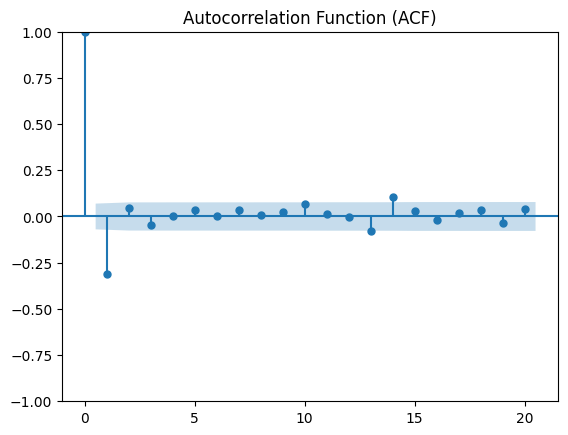

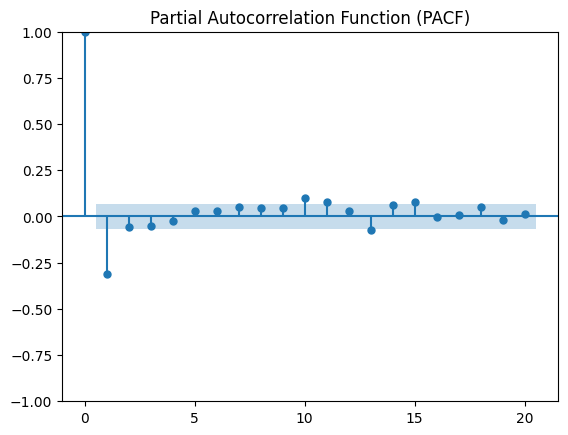

In [255]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(diff_data, lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(diff_data, lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

#### For ARMA(p, q), p can be from (1, 10, 13, 15) and q can be from (1, 14, 13)

In [256]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data2, order=(15, 0, 13))
model_fit = model.fit()

    # Predict the next value
yhat = model_fit.predict(start=len(train_data2), end=len(train_data2) + len(test_data2) - 1)


In [257]:
b = train_data['deseasonalized'][-1]

yhat.iloc[0] += b

yhat = yhat.cumsum()

In [258]:
ARMA_mae = np.mean(np.abs(yhat.values - test_data['deseasonalized'].values))

In [259]:
print(ARMA_mae)

3.78355025626874
